In [2]:
import pyspark.sql.functions as F

In [2]:
spark = SparkSession.builder.appName("SparkNLP").config("spark.driver.memory", "5g").getOrCreate()

In [24]:
metadata_df = spark.read.json('gs://msca-bdp-project-goodreads/goodreads_books.json')
interactions_df = spark.read.option("header", "true").csv('gs://msca-bdp-project-goodreads/goodreads_interactions.csv')

In [3]:
interactions_df.show(1,vertical=True)

-RECORD 0----------
 user_id     | 0   
 book_id     | 948 
 is_read     | 1   
 rating      | 5   
 is_reviewed | 0   
only showing top 1 row



In [4]:
interactions_df.filter(F.col('is_read')==0).show(5,vertical=True)

-RECORD 0----------
 user_id     | 0   
 book_id     | 913 
 is_read     | 0   
 rating      | 0   
 is_reviewed | 1   
-RECORD 1----------
 user_id     | 0   
 book_id     | 911 
 is_read     | 0   
 rating      | 0   
 is_reviewed | 0   
-RECORD 2----------
 user_id     | 0   
 book_id     | 910 
 is_read     | 0   
 rating      | 0   
 is_reviewed | 1   
-RECORD 3----------
 user_id     | 0   
 book_id     | 907 
 is_read     | 0   
 rating      | 0   
 is_reviewed | 0   
-RECORD 4----------
 user_id     | 0   
 book_id     | 906 
 is_read     | 0   
 rating      | 0   
 is_reviewed | 0   
only showing top 5 rows



In [7]:
interactions_df.count()

228648342

In [8]:
interactions_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- is_read: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- is_reviewed: string (nullable = true)



In [9]:
interactions_df.selectExpr(*["sum(case when {} is null then 1 else 0 end) as {}".format(c, c) for c in interactions_df.columns]).show()

+-------+-------+-------+------+-----------+
|user_id|book_id|is_read|rating|is_reviewed|
+-------+-------+-------+------+-----------+
|      0|      0|      0|     0|          0|
+-------+-------+-------+------+-----------+



In [10]:
interactions_df.select(F.col('user_id')).distinct().count(),interactions_df.select(F.col('book_id')).distinct().count()

(876145, 2360650)

In [11]:
interactions_df.select(F.col('rating')).distinct().show()

+------+
|rating|
+------+
|     3|
|     0|
|     5|
|     1|
|     4|
|     2|
+------+



In [18]:
interactions_df.select(F.col('is_read')).distinct().show(), interactions_df.select(F.col('is_reviewed')).distinct().show()

KeyboardInterrupt: 

In [14]:
user_books = interactions_df.filter(F.col('is_read')==1).groupBy("user_id").agg(F.collect_set("book_id").alias("books_read"))

In [15]:
user_books.count()

836433

In [20]:
user_books.show(5,vertical=True)

-RECORD 0--------------------------
 user_id    | 100010               
 books_read | [41585, 13098, 10... 
-RECORD 1--------------------------
 user_id    | 100090               
 books_read | [129074, 339574, ... 
-RECORD 2--------------------------
 user_id    | 100129               
 books_read | [1022252, 1047, 9... 
-RECORD 3--------------------------
 user_id    | 100140               
 books_read | [93854, 1012, 134... 
-RECORD 4--------------------------
 user_id    | 100156               
 books_read | [50675, 22143, 50... 
only showing top 5 rows



## CONTENT BASED FILTERING

In [3]:
metadata_df.show(1,vertical=True)

NameError: name 'metadata_df' is not defined

In [25]:
metadata_df = metadata_df.withColumn('average_rating',F.col('average_rating').cast('float'))
metadata_df = metadata_df.withColumn('ratings_count',F.col('ratings_count').cast('float'))

In [26]:
metadata_df = metadata_df.withColumn('weighted_rating',F.col('average_rating')*F.col('ratings_count'))

In [27]:
metadata_df.select('title','ratings_count','average_rating','weighted_rating').orderBy(F.col('weighted_rating').desc()).show(10,truncate=False)

+-----------------------------------------------------------+-------------+--------------+---------------+
|title                                                      |ratings_count|average_rating|weighted_rating|
+-----------------------------------------------------------+-------------+--------------+---------------+
|The Hunger Games (The Hunger Games, #1)                    |4899965.0    |4.34          |2.1265848E7    |
|Harry Potter and the Sorcerer's Stone (Harry Potter, #1)   |4765497.0    |4.45          |2.120646E7     |
|Twilight (Twilight, #1)                                    |3941381.0    |3.57          |1.407073E7     |
|To Kill a Mockingbird                                      |3255518.0    |4.26          |1.3868507E7    |
|The Great Gatsby                                           |2758812.0    |3.89          |1.0731779E7    |
|The Fault in Our Stars                                     |2429317.0    |4.26          |1.0348891E7    |
|The Hobbit                          

### reviews based recommendation

In [2]:
!pip show spark-nlp

Name: spark-nlp
Version: 4.4.0
Summary: John Snow Labs Spark NLP is a natural language processing library built on top of Apache Spark ML. It provides simple, performant & accurate NLP annotations for machine learning pipelines, that scale easily in a distributed environment.
Home-page: https://github.com/JohnSnowLabs/spark-nlp
Author: John Snow Labs
Author-email: 
License: 
Location: /opt/conda/miniconda3/lib/python3.8/site-packages
Requires: 
Required-by: spark-nlp-display


In [4]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml.feature import *
#from sparknlp.pretrained import PretrainedPipeline

In [5]:
reviews_df = spark.read.json("gs://msca-bdp-project-goodreads/goodreads_reviews_dedup.json")

In [34]:
reviews_df.count()

15739967

In [36]:
reviews_df.show(1,vertical=True)

-RECORD 0----------------------------
 book_id      | 24375664             
 date_added   | Fri Aug 25 13:55:... 
 date_updated | Mon Oct 09 08:55:... 
 n_comments   | 0                    
 n_votes      | 16                   
 rating       | 5                    
 read_at      | Sat Oct 07 00:00:... 
 review_id    | 5cd416f3efc3f944f... 
 review_text  | Mind blowingly co... 
 started_at   | Sat Aug 26 00:00:... 
 user_id      | 8842281e1d1347389... 
only showing top 1 row



In [4]:
concatenated_reviews = reviews_df.groupby('book_id').agg(F.concat_ws(" ", F.collect_list("review_text")).alias("concatenated_reviews"))

In [5]:
concatenated_reviews.write.option('index',False).parquet('gs://msca-bdp-project-goodreads/concatenated_reviews/')

In [4]:
concatenated_reviews = spark.read.parquet("gs://msca-bdp-project-goodreads/concatenated_reviews/").limit(100)

In [5]:
concatenated_reviews.write.mode('overwrite').option('index',False).parquet('gs://msca-bdp-project-goodreads/concatenated_reviews_limited/')

In [6]:
concatenated_reviews = spark.read.parquet("gs://msca-bdp-project-goodreads/concatenated_reviews_limited/")

In [13]:
del reviews_df

In [7]:
concatenated_reviews.show(1)

+--------+--------------------+
| book_id|concatenated_reviews|
+--------+--------------------+
|10000053|Well, it was a da...|
+--------+--------------------+
only showing top 1 row



In [7]:
#bart = BartTransformer.load("gs://msca-bdp-project-goodreads/BART-LARGE-CNN/").setTask("summarize:").setMaxOutputLength(500).setInputCols(["concatenated_reviews"]).setOutputCol("summary_final")

### review summarization

In [6]:
document_assembler = DocumentAssembler().setInputCol("concatenated_reviews").setOutputCol("documents")

t5 = T5Transformer().pretrained("t5_small").setTask("summarize:").setMaxOutputLength(50).setInputCols(["documents"]).setOutputCol("summaries")

finisher = Finisher().setInputCols(["summaries"]).setOutputCols(["human_readable_summaries"]).setOutputAsArray(False)

pipeline = Pipeline().setStages([document_assembler, t5, finisher])

t5_small download started this may take some time.
Approximate size to download 241.9 MB
[ | ]t5_small download started this may take some time.
Approximate size to download 241.9 MB
Download done! Loading the resource.
[ / ]

[ / ]

2023-11-17 02:12:20.914346: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 02:12:21.101449: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65798144 exceeds 10% of free system memory.
2023-11-17 02:12:21.303382: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65798144 exceeds 10% of free system memory.
2023-11-17 02:12:21.816871: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65798144 exceeds 10% of free system memory.
2023-11-17 02:12:21.866890: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65798144 exceeds 10% o

[ — ]

2023-11-17 02:12:22.236683: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65798144 exceeds 10% of free system memory.


[OK!]


In [8]:
results = pipeline.fit(concatenated_reviews).transform(concatenated_reviews)

In [9]:
#del document_assembler,t5,finisher,pipeline

In [10]:
results.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- concatenated_reviews: string (nullable = true)
 |-- human_readable_summaries: string (nullable = true)



In [11]:
results_new = results.select('book_id','human_readable_summaries')

In [12]:
results_new.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- human_readable_summaries: string (nullable = true)



In [11]:
results_new.rdd.getNumPartitions()

2

In [12]:
results_new = results_new.repartition(20)

In [14]:
results.show(1,vertical=True,truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
results_new.describe()

NameError: name 'results_new' is not defined

In [13]:
results_new.count()

23/11/17 01:30:48 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1700181149142_0004_01_000003 on host: hub-msca-bdp-dphub-students-test2-johnk-dheeraj-w-0.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2023-11-17 01:30:47.960]Container killed on request. Exit code is 137
[2023-11-17 01:30:47.961]Container exited with a non-zero exit code 137. 
[2023-11-17 01:30:47.962]Killed by external signal
.
23/11/17 01:30:48 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 3 for reason Container from a bad node: container_1700181149142_0004_01_000003 on host: hub-msca-bdp-dphub-students-test2-johnk-dheeraj-w-0.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2023-11-17 01:30:47.960]Container killed on request. Exit code is 137
[2023-11-17 01:30:47.961]Container exited with a non-zero exit code 137. 
[2023-11-17 01:30:47.962]Killed by external signal
.
23/11

KeyboardInterrupt: 

In [7]:
results.write.option('index',False).mode("overwrite").parquet('gs://msca-bdp-project-goodreads/reviews_summarized/')

23/11/16 02:37:26 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1700094955838_0019_01_000001 on host: hub-msca-bdp-dphub-students-dheeraj-w-0.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2023-11-16 02:37:25.784]Container killed on request. Exit code is 137
[2023-11-16 02:37:25.787]Container exited with a non-zero exit code 137. 
[2023-11-16 02:37:25.788]Killed by external signal
.
23/11/16 02:37:26 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Container from a bad node: container_1700094955838_0019_01_000001 on host: hub-msca-bdp-dphub-students-dheeraj-w-0.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2023-11-16 02:37:25.784]Container killed on request. Exit code is 137
[2023-11-16 02:37:25.787]Container exited with a non-zero exit code 137. 
[2023-11-16 02:37:25.788]Killed by external signal
.
23/11/16 02:37:26 ERROR org.a

KeyboardInterrupt: 

23/11/16 02:41:51 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1700094955838_0019_01_000003 on host: hub-msca-bdp-dphub-students-dheeraj-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2023-11-16 02:41:51.083]Container killed on request. Exit code is 137
[2023-11-16 02:41:51.084]Container exited with a non-zero exit code 137. 
[2023-11-16 02:41:51.085]Killed by external signal
.
23/11/16 02:41:51 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 3 for reason Container from a bad node: container_1700094955838_0019_01_000003 on host: hub-msca-bdp-dphub-students-dheeraj-w-1.c.msca-bdp-student-ap.internal. Exit status: 137. Diagnostics: [2023-11-16 02:41:51.083]Container killed on request. Exit code is 137
[2023-11-16 02:41:51.084]Container exited with a non-zero exit code 137. 
[2023-11-16 02:41:51.085]Killed by external signal
.
23/11/16 02:41:51 ERROR org.a

### summary similarity

In [7]:
# Transforms the input text into a document usable by the SparkNLP pipeline.
document_assembler = DocumentAssembler().setInputCol('human_readable_summaries').setOutputCol('document')

# Separates the text into individual tokens (words and punctuation).
#tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('token')

# Encodes the text as a single vector representing semantic features.
sentence_encoder = UniversalSentenceEncoder.pretrained(name='tfhub_use_lg').setInputCols(['document']).setOutputCol('sentence_embeddings')

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_encoder])

# Fit the model to an empty data frame so it can be used on inputs.
empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)
light_pipeline = LightPipeline(pipeline_model)

tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[ | ]tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[ / ]Download done! Loading the resource.
[ \ ]

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


[OK!]

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42439)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5527/171762028.py", line 8, in <module>
    sentence_encoder = UniversalSentenceEncoder.pretrained(name='tfhub_use_lg').setInputCols(['document']).setOutputCol('sentence_embeddings')
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/sparknlp/annotator/embeddings/universal_sentence_encoder.py", line 211, in pretrained
    return ResourceDownloader.downloadModel(UniversalSentenceEncoder, name, lang, remote_loc)
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/sparknlp/pretrained/resource_downloader.py", line 96, in downloadModel
    j_obj = _internal._DownloadModel(reader.name, name, language, remote_loc, j_dwn).apply()
  File "/opt/conda/minicon

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:42439)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5527/171762028.py", line 8, in <module>
    sentence_encoder = UniversalSentenceEncoder.pretrained(name='tfhub_use_lg').setInputCols(['document']).setOutputCol('sentence_embeddings')
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/sparknlp/annotator/embeddings/universal_sentence_encoder.py", line 211, in pretrained
    return ResourceDownloader.downloadModel(UniversalSentenceEncoder, name, lang, remote_loc)
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/sparknlp/pretrained/resource_downloader.py", line 96, in downloadModel
    j_obj = _internal._DownloadModel(reader.name, name, language, remote_loc, j_dwn).apply()
  File "/opt/conda/minicon

Py4JError: An error occurred while calling z:com.johnsnowlabs.nlp.pretrained.PythonResourceDownloader.downloadModel

In [ ]:
phase

### EDA - REVIEWS WORD COUNT

In [6]:
reviews_df = reviews_df.select('book_id','review_text')

reviews_df = reviews_df.withColumn("words", F.split(reviews_df["review_text"], " "))

# Get the word count for each review
reviews_df = reviews_df.withColumn("word_count", F.size(reviews_df["words"]))

In [7]:
grouped_df = reviews_df.groupby('word_count').agg({"book_id": "count"})

In [8]:
grouped_df = grouped_df.toPandas()

In [13]:
grouped_df.head()

,word_count,count(book_id)
0,148,25666
1,496,3346
2,463,3884
3,471,3713
4,833,609


In [10]:
grouped_df.describe()

,word_count,count(book_id)
count,3672.000000,3672.000000
mean,1850.629902,4286.483388
std,1085.115978,18615.957918
min,1.000000,1.000000
25%,918.750000,4.000000
50%,1836.500000,21.500000
75%,2757.250000,431.500000
max,6665.000000,247255.000000


In [27]:
grouped_df = grouped_df.sort_values(by=['word_count'])

In [28]:
grouped_df["running_sum"] = grouped_df["count(book_id)"].cumsum()

In [29]:
grouped_df

,word_count,count(book_id),running_sum
601,1,247255,247255
3184,2,212377,459632
944,3,205567,665199
1862,4,185312,850511
1049,5,184496,1035007
...,...,...,...
1734,4999,1,15739963
3158,5202,1,15739964
2273,5443,1,15739965
3141,5454,1,15739966


In [32]:
grouped_df[grouped_df['word_count']<15]['count(book_id)'].sum()

2657619

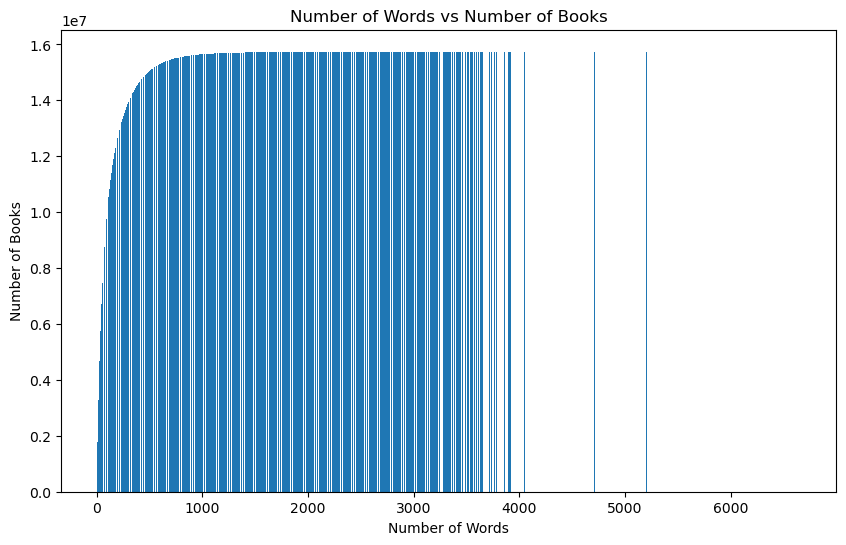

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(grouped_df["word_count"], grouped_df["running_sum"])
plt.xlabel("Number of Words")
plt.ylabel("Number of Books")
plt.title("Number of Words vs Number of Books")
plt.show()